In [1]:
!pip install qiskit==1.4.2
!pip install qiskit-algorithms
!pip install qiskit-aer
!pip install qiskit-optimization

  Using cached symengine-0.13.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 13.7 MB/s eta 0:00:00a 0:00:01
Using cached symengine-0.13.0-cp311-cp311-macosx_11_0_arm64.whl (22.7 MB)
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.1.1
    Uninstalling qiskit-2.1.1:
      Successfully uninstalled qiskit-2.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.5/646.5 kB 5.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 7.3 MB/s eta 0:00:00
  Created wheel for docplex: filename=docplex-2.30.251-py3-none-any.whl size=685954 sha256=1705ae2437017a212289b44e80b364dc813c9a93ceb2f65de2203360d101b087
  Stored i

In [2]:
# Installing and importing the necessary libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from itertools import permutations
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_algorithms import VQE
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit import Parameter
from qiskit.circuit.library import TwoLocal
from qiskit_aer import QasmSimulator, Aer, AerSimulator
#from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
#from qiskit.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

{(0, 1): Text(0.5, 1.0, '5'),
 (0, 3): Text(0.0, 0.5, '5'),
 (0, 2): Text(0.5, 0.5, '2'),
 (1, 2): Text(1.0, 0.5, '5'),
 (1, 3): Text(0.5, 0.5, '2'),
 (2, 3): Text(0.5, 0.0, '5')}

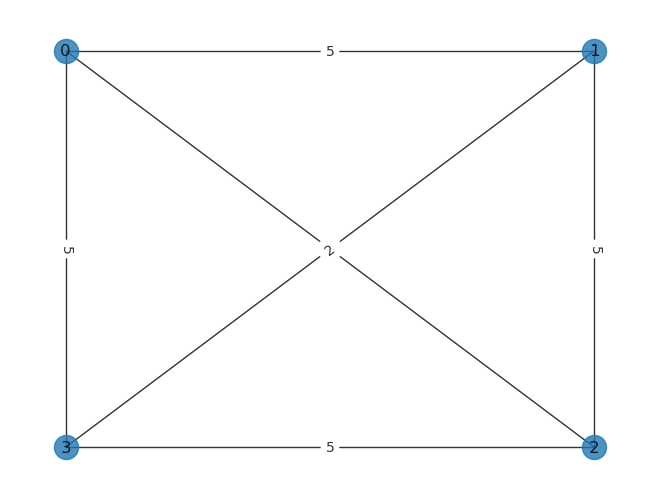

In [3]:
# Below we create the graph formulation of our Travelling Salesman Problem (TSP) instance.

G = nx.Graph()
G.add_node(0,pos=(0,1))
G.add_node(1,pos=(1,1))
G.add_node(2,pos=(1,0))
G.add_node(3,pos=(0,0))

G.add_edge(0, 1, weight=5)
G.add_edge(1, 2, weight=5)
G.add_edge(2, 3, weight=5)
G.add_edge(3, 0, weight=5)
G.add_edge(0, 2, weight=2)
G.add_edge(1, 3, weight=2)

pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos, with_labels=True, alpha=0.8)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, alpha=0.8, pos=pos, edge_labels=labels)

In [4]:
num_nodes = 4
adj_matrix = nx.adjacency_matrix(G).todense()
num_qubits = num_nodes ** 2

order = (0, 1, 2, 3) Distance = 20
order = (0, 1, 3, 2) Distance = 14
Best order from brute force = (0, 1, 3, 2) with total distance = 14


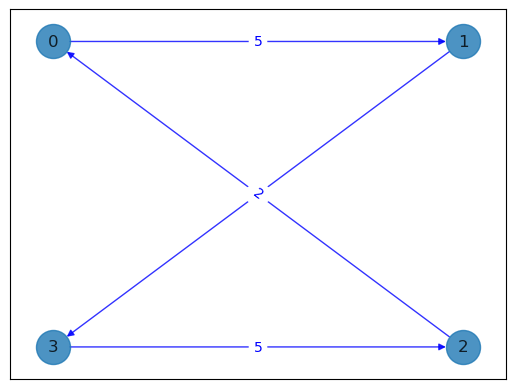

In [5]:
def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, num_nodes)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

tsp = Tsp(G)
draw_tsp_solution(tsp.graph, best_order, pos)

In [6]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  5*x_0_0*x_1_1 + 5*x_0_0*x_1_3 + 2*x_0_0*x_2_1 + 2*x_0_0*x_2_3 + 5*x_0_0*x_3_1
  + 5*x_0_0*x_3_3 + 5*x_0_1*x_1_0 + 5*x_0_1*x_1_2 + 2*x_0_1*x_2_0
  + 2*x_0_1*x_2_2 + 5*x_0_1*x_3_0 + 5*x_0_1*x_3_2 + 5*x_0_2*x_1_1
  + 5*x_0_2*x_1_3 + 2*x_0_2*x_2_1 + 2*x_0_2*x_2_3 + 5*x_0_2*x_3_1
  + 5*x_0_2*x_3_3 + 5*x_0_3*x_1_0 + 5*x_0_3*x_1_2 + 2*x_0_3*x_2_0
  + 2*x_0_3*x_2_2 + 5*x_0_3*x_3_0 + 5*x_0_3*x_3_2 + 5*x_1_0*x_2_1
  + 5*x_1_0*x_2_3 + 2*x_1_0*x_3_1 + 2*x_1_0*x_3_3 + 5*x_1_1*x_2_0
  + 5*x_1_1*x_2_2 + 2*x_1_1*x_3_0 + 2*x_1_1*x_3_2 + 5*x_1_2*x_2_1
  + 5*x_1_2*x_2_3 + 2*x_1_2*x_3_1 + 2*x_1_2*x_3_3 + 5*x_1_3*x_2_0
  + 5*x_1_3*x_2_2 + 2*x_1_3*x_3_0 + 2*x_1_3*x_3_2 + 5*x_2_0*x_3_1
  + 5*x_2_0*x_3_3 + 5*x_2_1*x_3_0 + 5*x_2_1*x_3_2 + 5*x_2_2*x_3_1
  + 5*x_2_2*x_3_3 + 5*x_2_3*x_3_0 + 5*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 + x_2_3 == 1  'c2'
    x_3_0 

In [7]:
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 3136.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIIZ', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIIZI', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIIZI', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIZII', 'IIIIIIIIZIIIIZII', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIZIIIIIIIIZII', 'IIZIIIIIIIIIIZII', 'IZIIIIIIII

In [8]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 14.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS


Energy: -3122.0000000000023
TSP objective: 13.999999999997726
Feasible: True
Solution: [3, 2, 0, 1]
Solution objective: 14.0


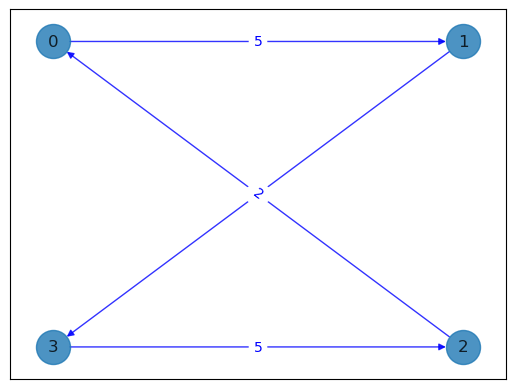

In [9]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("Energy:", result.eigenvalue.real)
print("TSP objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("Feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("Solution:", z)
print("Solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, pos)

energy: -2429.958984375
time: 7.844326972961426
feasible: True
solution: [3, 1, 0, 1]
solution objective: 14.0


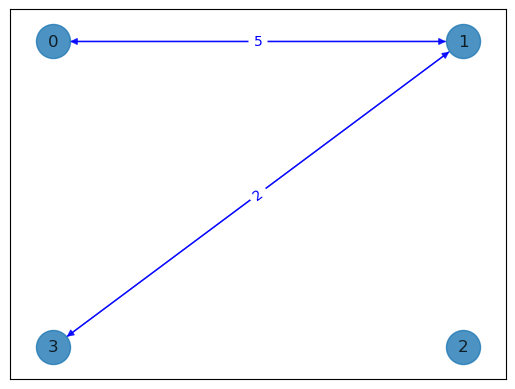

In [10]:
seed = 0
backend = Aer.get_backend("qasm_simulator")

spsa = SPSA(maxiter=100)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=1, entanglement="linear")

seed = 170

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

vqe = VQE(noiseless_estimator, ry, optimizer=spsa)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)

optimal_circuit = ry.assign_parameters(result.optimal_point)
num_qubits = qubitOp.num_qubits
qr = QuantumRegister(num_qubits)
cr = ClassicalRegister(num_qubits)
measured_circuit = QuantumCircuit(qr, cr)
measured_circuit.compose(optimal_circuit, inplace=True)
measured_circuit.measure(qr, cr)

from qiskit import transpile
transpiled_circuit = transpile(measured_circuit, backend=AerSimulator())

simulator = AerSimulator()
job = simulator.run(transpiled_circuit, shots=1024, seed_simulator=seed)
counts = job.result().get_counts(transpiled_circuit)
plot_histogram(counts)
x = tsp.sample_most_likely(counts)

print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, pos)

Inspiration:

https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html#Traveling-Salesman-Problem

https://arxiv.org/pdf/1302.5843.pdf

